In [8]:
from pyvis.network import Network
import networkx as nx
import numpy as np
import scipy
from scipy import sparse, io
import matplotlib
from matplotlib import pyplot as plt
from graph_tool import draw, inference

# An Exploration on Constructing RNA Seq Data as A Bipartite Graph

by Jiaying Lu (jiaying.lu@emory.edu)

## Read RNA Seq Dataset

RNA_seq_matrix ([1], [link](https://www.cell.com/cell/fulltext/S0092-8674(18)30955-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418309553%3Fshowall%3Dtrue)) is a sparse matrix where each entry stores gene expression "value" for specific gene (row) and cell (column) from mouse brain.
The gene expression is stored in interger which ranges from 0 to some positive number.

The analysis on such RNA_seq_matrix could help identify molecular markers for cell population, thus leading a better understand to the functions and interactions of cells in the brain.

In this report, I aim to explore how to represent such RNA_seq_matrix in a graph structure, and how the graph representation helps further analysis in the dataset.

[1] Saunders, Arpiar, et al. "Molecular diversity and specializations among the cells of the adult mouse brain." Cell 174.4 (2018): 1015-1030.

In [2]:
RNA_seq_matrix = io.mmread("data/FC_data_LRcell.mm.txt")

In [3]:
print("RNA_seq_matrix.shape: ", RNA_seq_matrix.shape)
print("Non-zero entry count=%d (%.2f%%)" % (RNA_seq_matrix.getnnz(), 
      RNA_seq_matrix.getnnz()/RNA_seq_matrix.shape[0]/RNA_seq_matrix.shape[1]*100))
print("Entry analysis: min=%d, max=%d, mean=%.3f" % (RNA_seq_matrix.min(), 
                                                     RNA_seq_matrix.max(),
                                                     RNA_seq_matrix.mean(),
                                                    ))

RNA_seq_matrix.shape:  (15976, 71639)
Non-zero entry count=137124604 (11.98%)
Entry analysis: min=0, max=1711, mean=0.251


Moreover, the data is reletively large scale and may contain noisy data, hence it is beneficial to **sample a subset** for further analysis.

### cell down-sampling

In [4]:
# cell analysis
cell_vec = RNA_seq_matrix.sum(0)
print("cell_vec shape =", cell_vec.shape)
print("Entry analysis: min=%d, max=%d, mean=%.3f, std=%.3f" % (cell_vec.min(), cell_vec.max(), 
                                                               cell_vec.mean(), cell_vec.std()))

cell_vec shape = (1, 71639)
Entry analysis: min=611, max=73424, mean=4009.060, std=3355.501


Because the original data is stored in R data format, and R is powful for analysing, plotting big scale sparse data, the above images are generated by R scripts.

```R
data = readRDS("data/FC_data_LRcell.RDS")
hist(log10(colSums(data)), main="Histogram of Total Gene Expression Per Cell", ylab="log10")
```
![column](data/Column.hist)

From the histogram, there exists a potential threshold, 10^3.3, for dicarding low gene expression cells.  
However, to reserve the distribution of different cell types, I follow their frequencies in the dataset.  
The dataset contains **71639** cells, and I plan to downsample it to around **7K** (10%) cells.

len(cell_name_type_dict)=71639, len(cell_type)=81
cell_type_counter: Counter({'FC_6-1': 15003, 'FC_6-3': 11719, 'FC_6-4': 11549, 'FC_8-1': 4132, 'FC_9-4': 1772, 'FC_4-1': 1501, 'FC_12-1': 1490, 'FC_3-3': 1451, 'FC_12-3': 1336, 'FC_7-6': 1213, 'FC_3-7': 1010, 'FC_12-4': 926, 'FC_3-1': 863, 'FC_9-1': 778, 'FC_9-5': 734, 'FC_7-3': 708, 'FC_8-2': 690, 'FC_3-12': 678, 'FC_1-1': 658, 'FC_3-4': 655, 'FC_3-8': 610, 'FC_5-1': 567, 'FC_2-7': 533, 'FC_11-1': 500, 'FC_1-2': 484, 'FC_13-2': 442, 'FC_2-9': 442, 'FC_9-3': 435, 'FC_3-9': 425, 'FC_10-1': 417, 'FC_13-1': 384, 'FC_1-5': 376, 'FC_2-8': 376, 'FC_1-6': 359, 'FC_6-5': 332, 'FC_6-2': 325, 'FC_3-13': 318, 'FC_10-5': 267, 'FC_2-4': 242, 'FC_2-2': 241, 'FC_2-5': 224, 'FC_1-4': 223, 'FC_10-6': 217, 'FC_7-1': 204, 'FC_1-10': 202, 'FC_7-2': 200, 'FC_1-11': 193, 'FC_3-10': 192, 'FC_3-2': 188, 'FC_10-3': 185, 'FC_3-5': 177, 'FC_13-3': 156, 'FC_3-6': 153, 'FC_11-3': 149, 'FC_2-10': 148, 'FC_1-9': 145, 'FC_2-3': 131, 'FC_7-7': 129, 'FC_1-7': 118, 'FC_1

<BarContainer object of 81 artists>

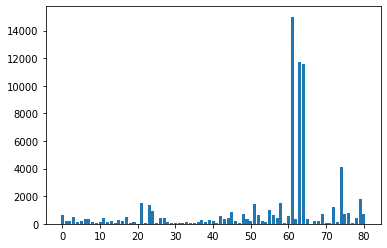

In [17]:
# Load cell type distribution
from collections import Counter
cell_name_type_tuple_list = []
cell_type_counter = Counter()
with open("data/FC_cells_annot.csv") as fopen:
    for line in fopen:
        cell_name, cell_type = line.strip().split(',')
        cell_name_type_tuple_list.append((cell_name, cell_type))
        cell_type_counter[cell_type] += 1
print("len(cell_name_type_dict)=%d, len(cell_type)=%d" % (len(cell_name_type_dict), len(cell_type_counter)))
print("cell_type_counter:", cell_type_counter)
plt.bar(np.arange(len(cell_type_counter)), cell_type_counter.values())

Finally kept 3599 cells


<BarContainer object of 81 artists>

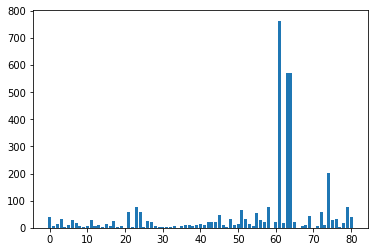

In [24]:
import random
cell_subsample_type_counter = {k: 0 for k, v in cell_type_counter.items()}
kept_cells = []
for idx, (cell_n, cell_t) in enumerate(cell_name_type_tuple_list):
    if random.random() <= 0.05:
        kept_cells.append(idx)
        cell_subsample_type_counter[cell_t] += 1
print("Finally kept %d cells" % (len(kept_cells)))
plt.bar(np.arange(len(cell_subsample_type_counter)), cell_subsample_type_counter.values())

From the above bar charts, it is obvious the original cell type distribution is approximately reserved.


### Gene Down-sampling

```R
hist(rowSums(data>0), main="Histogram of Cell Proportion Expressed Per Gene", ylab="Frequency")
```

![row](data/Row.hist)

From the above histogram, there are around 10K genes have cell frequency < 20K which means they are not significantly expressed among all cells in the dataset.  
The gene number after down-sampling is expected to have similar propotion in the original dataset, hence I choose 40K as the threshold.

In [25]:
# Gene analysis
gene_vec = RNA_seq_matrix.sum(1)
print("Gene vec shape", gene_vec.shape)

Gene vec shape (15976, 1)


In [30]:
kept_genes = []
for idx, s in enumerate(gene_vec[:,0]):
    if s > 40000:
        kept_genes.append(idx)
print("kept genes=", len(kept_genes))

kept genes= 1583


In [37]:
# save gene expression matrix
RNA_seq_matrix_sampled = RNA_seq_matrix.tocsr()[kept_genes, :][:, kept_cells]
print("After sampling, RNA_seq_matrix shape=", RNA_seq_matrix_sampled.shape)
RNA_seq_matrix = None
io.mmwrite("data/FC_data_LRcell.sampled.mm.txt", RNA_seq_matrix_sampled)

After sampling, RNA_seq_matrix shape= (1583, 3599)


In [38]:
# save attached information
with open('data/FC_data_LRcell.colnames.txt') as fopen, open('data/FC_data_LRcell.sampled.colnames.txt', 'w') as fwrite:
    for idx, line in enumerate(fopen):
        if idx in kept_cells:
            fwrite.write(line)
            
with open('data/FC_data_LRcell.rownames.txt') as fopen, open('data/FC_data_LRcell.sampled.rownames.txt', 'w') as fwrite:
    for idx, line in enumerate(fopen):
        if idx in kept_genes:
            fwrite.write(line)

# Build Bipartite Graph

Inspired by the author-venue bipartite graph, the RNA-seq matrix can be formulated as a bipartite graph whose vertices are gene vertices and cell vertices.

Another critical issue is that the gene cell graph is relatively big, then `networkx` has suffered severely from scalability issues.  
I switch to C++ implemented `graph-tool` for efficient computation.

In [3]:
RNA_seq_matrix_sampled = io.mmread("data/FC_data_LRcell.sampled.mm.txt").tocsr()
with open("data/FC_data_LRcell.sampled.colnames.txt") as fopen:
    cell_names = [l.strip() for l in fopen.readlines()]
with open("data/FC_data_LRcell.sampled.rownames.txt") as fopen:
    gene_names = [l.strip() for l in fopen.readlines()]
print("RNA_seq_matrix_sampled shape=%s, cell_names cnt=%d, gene_names cnt=%d" % 
      (RNA_seq_matrix_sampled.shape, len(cell_names), len(gene_names)))
rows, cols = RNA_seq_matrix_sampled.nonzero()

RNA_seq_matrix_sampled shape=(1583, 3599), cell_names cnt=3599, gene_names cnt=1583


In [4]:
import graph_tool
B = graph_tool.Graph(directed=False)
# Add vertex. Gene vertices start from 0, Cell vertices start from len(gene_names)
B.add_vertex(len(gene_names)+len(cell_names))
# Add edges
edges = [(r, w+len(gene_names)) for (r, w) in zip(rows, cols)]
B.add_edge_list(edges)
B.edge_properties["eweight"] = B.new_ep("int")
B.edge_properties["eweight"].a = np.array([RNA_seq_matrix_sampled[r,w] for (r, w) in zip(rows, cols)])

In [5]:
# Add cell types
B.vertex_properties["cell_type"] = B.new_vp("string")
cell_name_type_dict = {}
with open("data/FC_cells_annot.csv") as fopen:
    for line in fopen:
        cell_name, cell_type = line.strip().split(',')
        cell_name_type_dict[cell_name] = cell_type
for idx, cell_name in enumerate(cell_names):
    cell_type = cell_name_type_dict[cell_name]
    B.vertex_properties["cell_type"][B.vertex(len(gene_names)+idx)] = cell_type
    
# Add vertex names
B.vertex_properties["vname"] = B.new_vp("string")
for idx, gene_name in enumerate(gene_names):
    B.vertex_properties["vname"][B.vertex(idx)] = gene_name
for idx, cell_name in enumerate(cell_names):
    B.vertex_properties["vname"][B.vertex(len(gene_names)+idx)] = cell_name

# Graph Analysis

First, let's take a look at some basic stats.

In [6]:
from graph_tool import stats, clustering, topology
print("Gene-Cell Bipartitie Graph basic info:", B)
print("After graph construction, there are following attached attributes:")
print(B.list_properties())
print("Vertex average degree (avg, std) =", stats.vertex_average(B, "total"))
print("is_bipartite =", topology.is_bipartite(B))

Gene-Cell Bipartitie Graph basic info: <Graph object, undirected, with 5182 vertices and 2916778 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fa2c5c46b00>
After graph construction, there are following attached attributes:
cell_type      (vertex)  (type: string)
vname          (vertex)  (type: string)
eweight        (edge)    (type: int32_t)
None
Vertex average degree (avg, std) = (1125.7344654573524, 8.692496948125177)
is_bipartite = True


Text(0.5, 1.0, 'Gene-Cell Bipartite Degree Distribution')

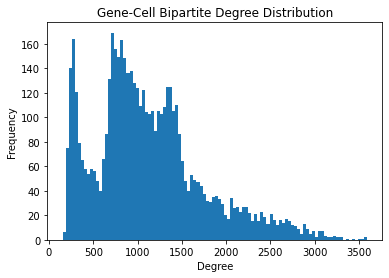

In [6]:
all_degrees = B.get_total_degrees(B.get_vertices())
plt.hist(all_degrees, 100)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Gene-Cell Bipartite Degree Distribution")

From the degree distribution figure, the gene-cell graph does follow the "Heavy-tailed distribution" to some extent.  
This is attributed to the down-sampling strategy I applied to the original data since the low gene expression cells and genes are discarded.

Text(0.5, 1.0, 'Cell Vertices')

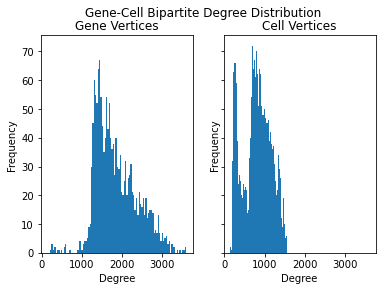

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle("Gene-Cell Bipartite Degree Distribution")

gene_degrees = B.get_total_degrees(range(len(gene_names)))
ax1.hist(gene_degrees, 100)
ax1.set(xlabel="Degree", ylabel="Frequency")
ax1.set_title("Gene Vertices")

cell_degrees = B.get_total_degrees(range(len(gene_names), len(gene_names)+len(cell_names)))
ax2.hist(cell_degrees, 100)
ax2.set(xlabel="Degree", ylabel="Frequency")
ax2.set_title("Cell Vertices")

The impact of down-sampling can also be observed in the seperated Gene and Cell vertices degree distribution histograms.  
Low expression genes are discarded with a hard cut-off, thus leading its degree distribution has a peak when degree is around 1300. Strating from degree=1300, the distribution follows the "Heavy-tailed distribution".
Similar phenomenon applies for cell vertices, too.

In [56]:
clust = clustering.local_clustering(B)
print("average local clustering coefficient", stats.vertex_average(B, clust))

average local clustering coefficient (0.0, 0.0)


It turns out that the graph has a quite low clustering coefficient, which follows its bipartitie and sparse property.

[array([       0.,  5833416., 15453795.,  5560731.]), array([0, 1, 2, 3, 4], dtype=uint64)]


Text(0.5, 1.0, 'Gene-Cell Bipartite Shortest Path Distance Histogram')

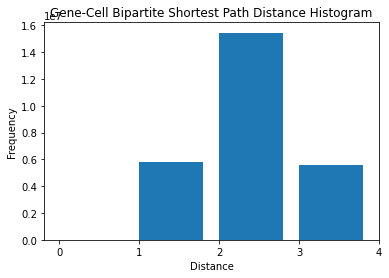

In [77]:
dist_hist = stats.distance_histogram(B)
plt.bar(dist_hist[1][:-1], dist_hist[0], width=0.8, align="edge")
plt.xticks(dist_hist[1])
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Gene-Cell Bipartite Shortest Path Distance Histogram")

From the shortest path distance histogram, the graph's diameter is 3. And most vertices are two-hops away.

## Draw Graph

It is important to see what the graph strcuture looks like.  
However, current graph is still too large to be plotted.  
For the visulization purpose, a subgraph is presented.

In [7]:
# Subgraph filter
B.clear_filters()
efilt = B.new_edge_property('bool', val=False)
vfilt = B.new_vertex_property('bool', val=False)
for idx in range(B.num_vertices()):
    if (0 == idx % 50):
        vfilt[idx] = True
for idx, edge in enumerate(B.edges()):
    if vfilt[edge.source()] and vfilt[edge.target()]:
        efilt[edge] = True
B.set_edge_filter(efilt)
B.set_vertex_filter(vfilt)

B_sub = B.copy()
B_sub.purge_vertices()
B_sub.purge_edges()
print("After filter, graph has %d vertices, %d edges" % (B_sub.num_vertices(), B_sub.num_edges()))
print("is_bipartite =", topology.is_bipartite(B_sub))

After filter, graph has 104 vertices, 1245 edges
is_bipartite = True


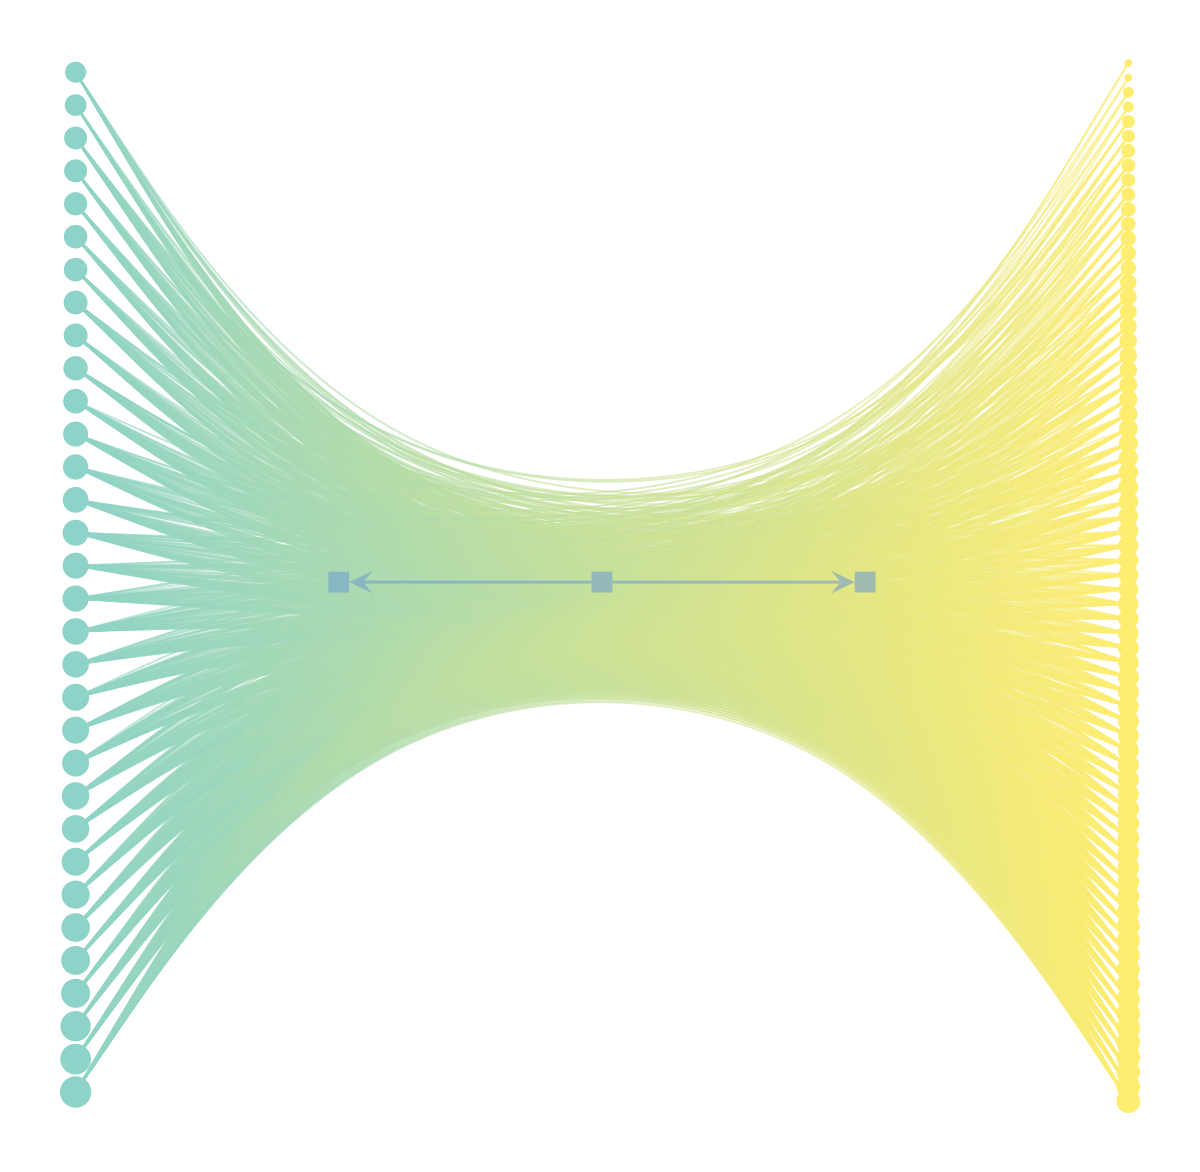

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcae9a5d0f0, at 0x7fcae99bfe10>,
 <Graph object, directed, with 107 vertices and 106 edges, at 0x7fcae96750f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcae96750f0, at 0x7fcae95cd9e8>)

In [22]:
#draw.draw_hierarchy(state, layout="bipartite", output="celegansneural_nested_mdl.pdf")
state = inference.minimize_nested_blockmodel_dl(B_sub, deg_corr=True)
draw.draw_hierarchy(state, layout="bipartite")

## Node Analysis

After the basic graph-level analysis, and visualization. It is worth to investigate some node-level properties.  
The following analysis is based on the subsampled graph for figure simplicity and computational efficiency.

In [9]:
from graph_tool import centrality
pos = draw.sfdp_layout(B_sub)

/home/jlu229/playground/FA20_CS584/venv-py3.7.3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:634: UserWarning: Unknown parameter: ertex_fill_color
  warnings.warn("Unknown parameter: " + k, UserWarning)


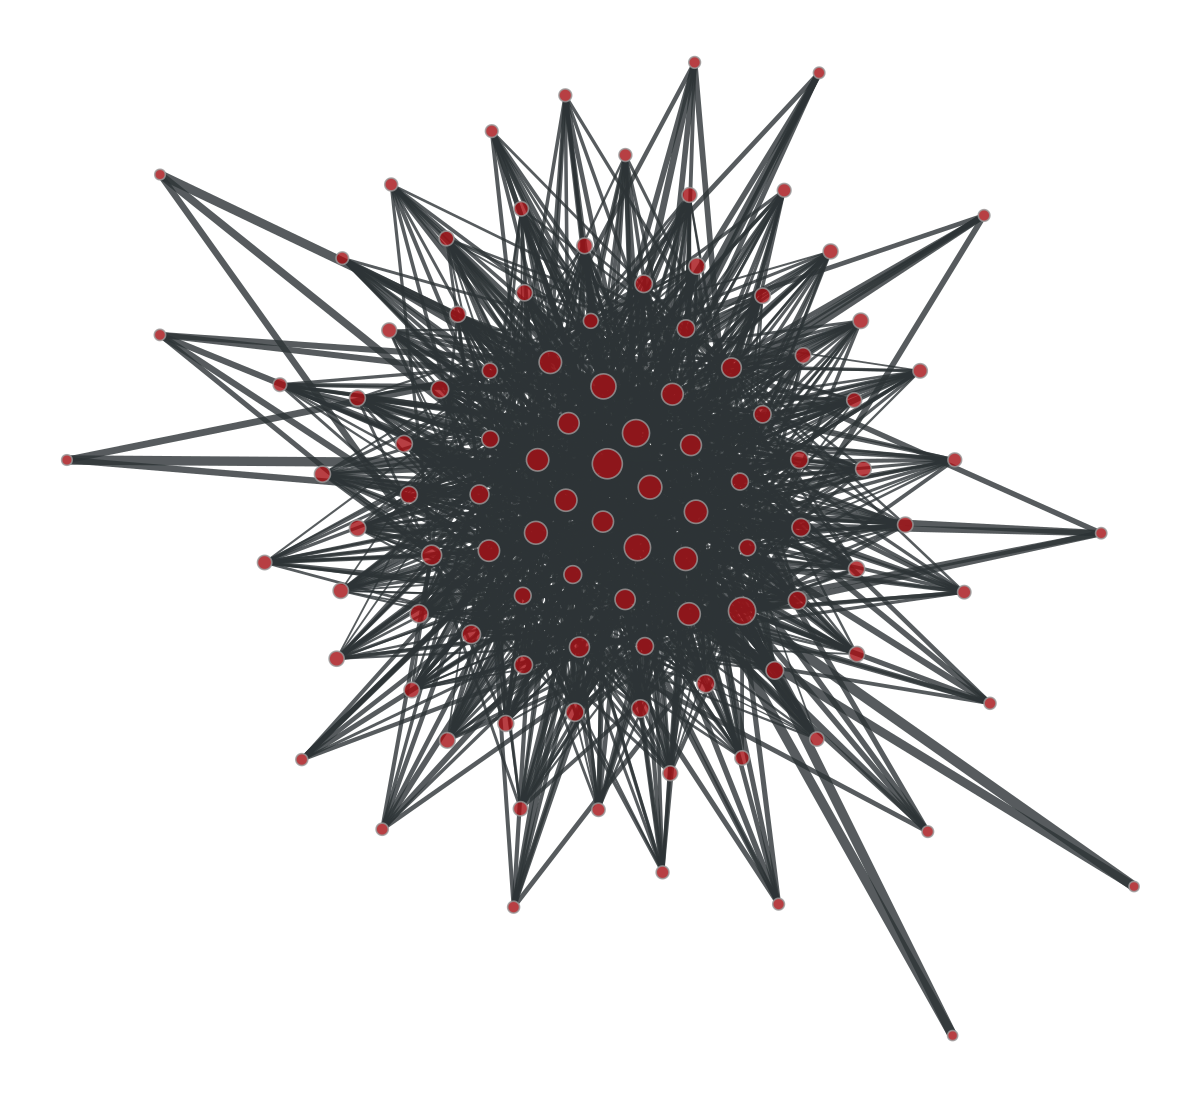

Central point dominance 0.055778176587419535


In [26]:
vp, ep = centrality.betweenness(B_sub)
draw.graph_draw(B_sub, pos=pos, ertex_fill_color=vp,
                vertex_size=draw.prop_to_size(vp, mi=5, ma=15),
                edge_pen_width=draw.prop_to_size(ep, mi=0.5, ma=5),
                vcmap=matplotlib.cm.gist_heat, vorder=vp)
cp = centrality.central_point_dominance(B_sub, vp)
print("Central point dominance", cp)

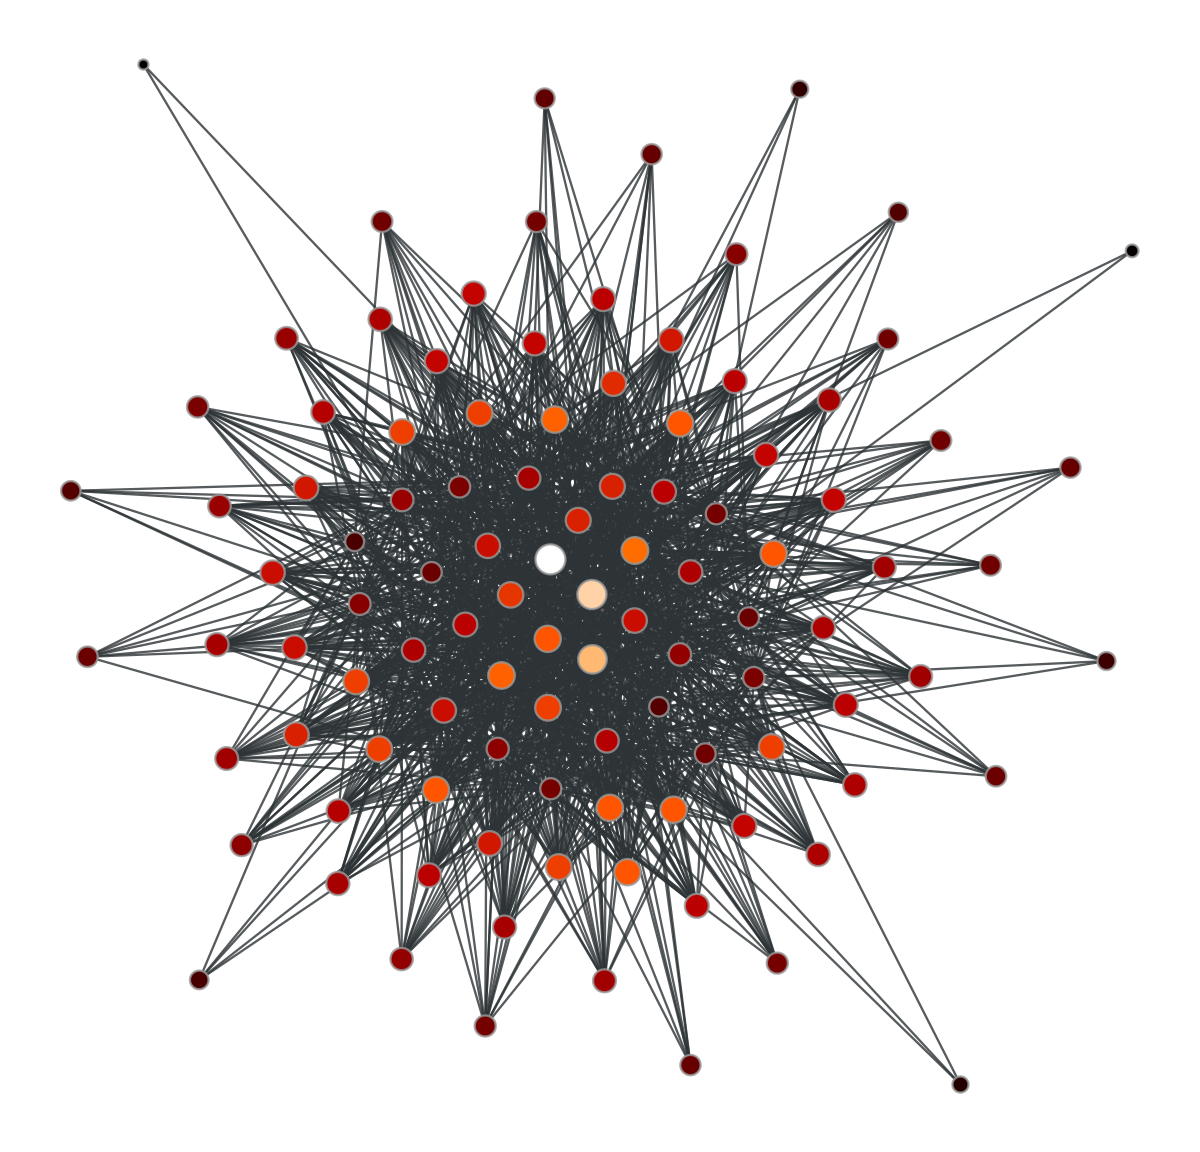

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2aa151e10, at 0x7fa2aa134f28>

In [12]:
c = centrality.closeness(B_sub)
draw.graph_draw(B_sub, pos=pos, vertex_fill_color=c,
                vertex_size=draw.prop_to_size(c, mi=5, ma=15),
                vcmap=matplotlib.cm.gist_heat,
                vorder=c)

In [17]:
topk_idx = np.flip(np.array(c.a).argsort())[:20]
for idx in topk_idx:
    print(B_sub.vp["vname"][B_sub.vertex(idx)], B_sub.vp["cell_type"][B_sub.vertex(idx)])

Ywhae 
Purb 
Ndrg4 
Sf3b2 
P60FCRep1P1_CTTCACATTGTC FC_6-4
Uchl1 
P60FCRep1P2_TTAACGCGGGCA FC_6-4
P60FCRep3P4_AGACAAAGTGGG FC_6-4
P60FCCx3cr1Rep1P3_GACTAGACCCAG FC_6-4
P60FCRep2P1_TCTAGGGATCAG FC_6-1
P60FCRep4P2_CGTCGTAAAAAT FC_6-4
Gcc2 
P60FCRep1P1_GTCCAGTCAACC FC_6-1
P60FCRep2P2_AGTCTTAGCATN FC_6-4
P60FCRep3P4_CTTCGGCAAGCT FC_6-3
Tppp 
P60FCRep3P2_ATGAAACAGTTA FC_6-3
P60FCRep3P1_TTGCATGGAGAA FC_6-1
P60FCAldh1l1Rep1P2_AAACATAGAGCT FC_6-1
P60FCRep3P2_TATGTCCGCGAC FC_6-4


From the top20 results derived from node closeness analysis, I find that among 81 cell types, `FC_6-4`, `FC_6-1` and `FC_6-3` may be most important cell types that can qulickly reach other vertices.  
For genes, `Ywhae, Purb, Ndrg4, Sf3b2` and etc are most important in terms of node closeness.

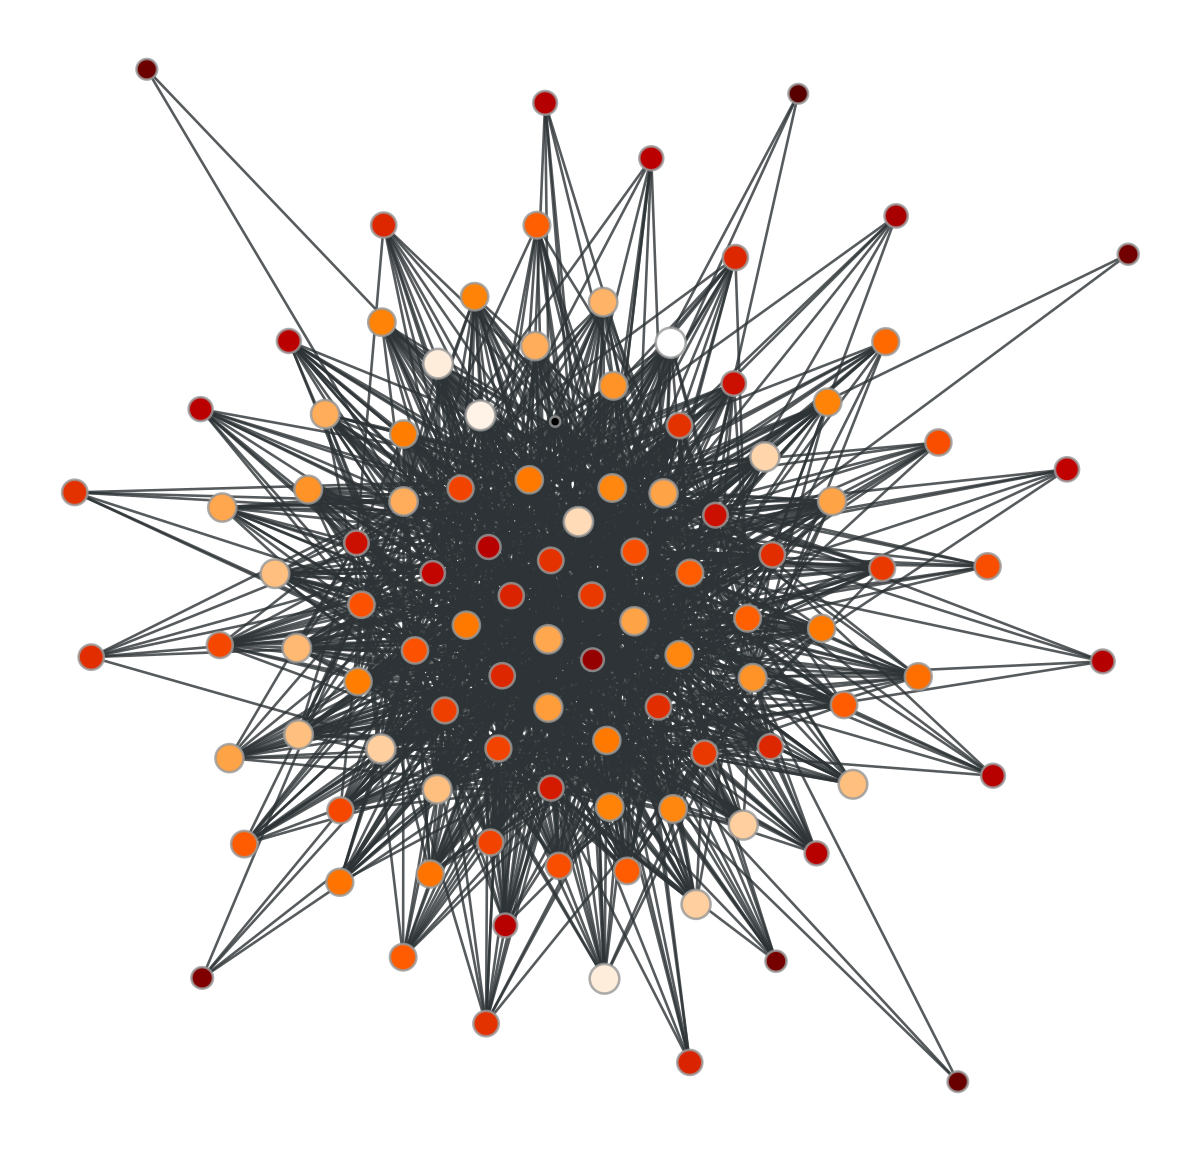

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2aa151e10, at 0x7fa2aa134f28>

In [19]:
# With edge weights inclcuded
c = centrality.closeness(B_sub, weight=B_sub.ep["eweight"])
draw.graph_draw(B_sub, pos=pos, vertex_fill_color=c,
                vertex_size=draw.prop_to_size(c, mi=5, ma=15),
                vcmap=matplotlib.cm.gist_heat,
                vorder=c)

In [20]:
topk_idx = np.flip(np.array(c.a).argsort())[:20]
for idx in topk_idx:
    print(B_sub.vp["vname"][B_sub.vertex(idx)], B_sub.vp["cell_type"][B_sub.vertex(idx)])

P60FCRep1P2_GCTAGATTGGTG FC_6-3
P60FCAldh1l1Rep1P2_AAACATAGAGCT FC_6-1
P60FCRep4P1_CTTAGCTAATAG FC_2-7
P60FCCx3cr1Rep1P2_GGGTGTCCGAGA FC_6-1
Prdx2 
P60FCRep4P3_TTGACTCCCCTT FC_3-4
P60FCRep3P1_TTGCATGGAGAA FC_6-1
P60FCRep2P2_TCCCTGGTGCGN FC_6-1
P60FCAldh1l1Rep1P3_TCAAAGTCAACC FC_6-3
P60FCAldh1l1Rep1P4_GAAACTTCGGCG FC_3-1
P60FCAldh1l1Rep1P3_CCTGGTATGCAC FC_6-4
P60FCRep6P3_TCGGTGGAAGAN FC_7-6
P60FCRep1P1_GTCCAGTCAACC FC_6-1
P60FCRep2P1_ATGTCTGAGGGA FC_4-1
P60FCRep3P3_GAACTGCACCCG FC_6-1
P60FCAldh1l1Rep1P1_GCCCAGCAGGAG FC_2-2
Map1lc3b 
P60FCCx3cr1Rep1P2_GTTCCTTCCTCT FC_6-3
P60FCCx3cr1Rep1P3_GAATACACCTCG FC_4-1
Gcc2 


The closeness result is quite different if the edge weights is included.  
However, it is hard to tell whether including weights or not including weights is better.

## Pair Analysis

The pair analysis can provide more insights if the results show that similar genes/cells are closer.

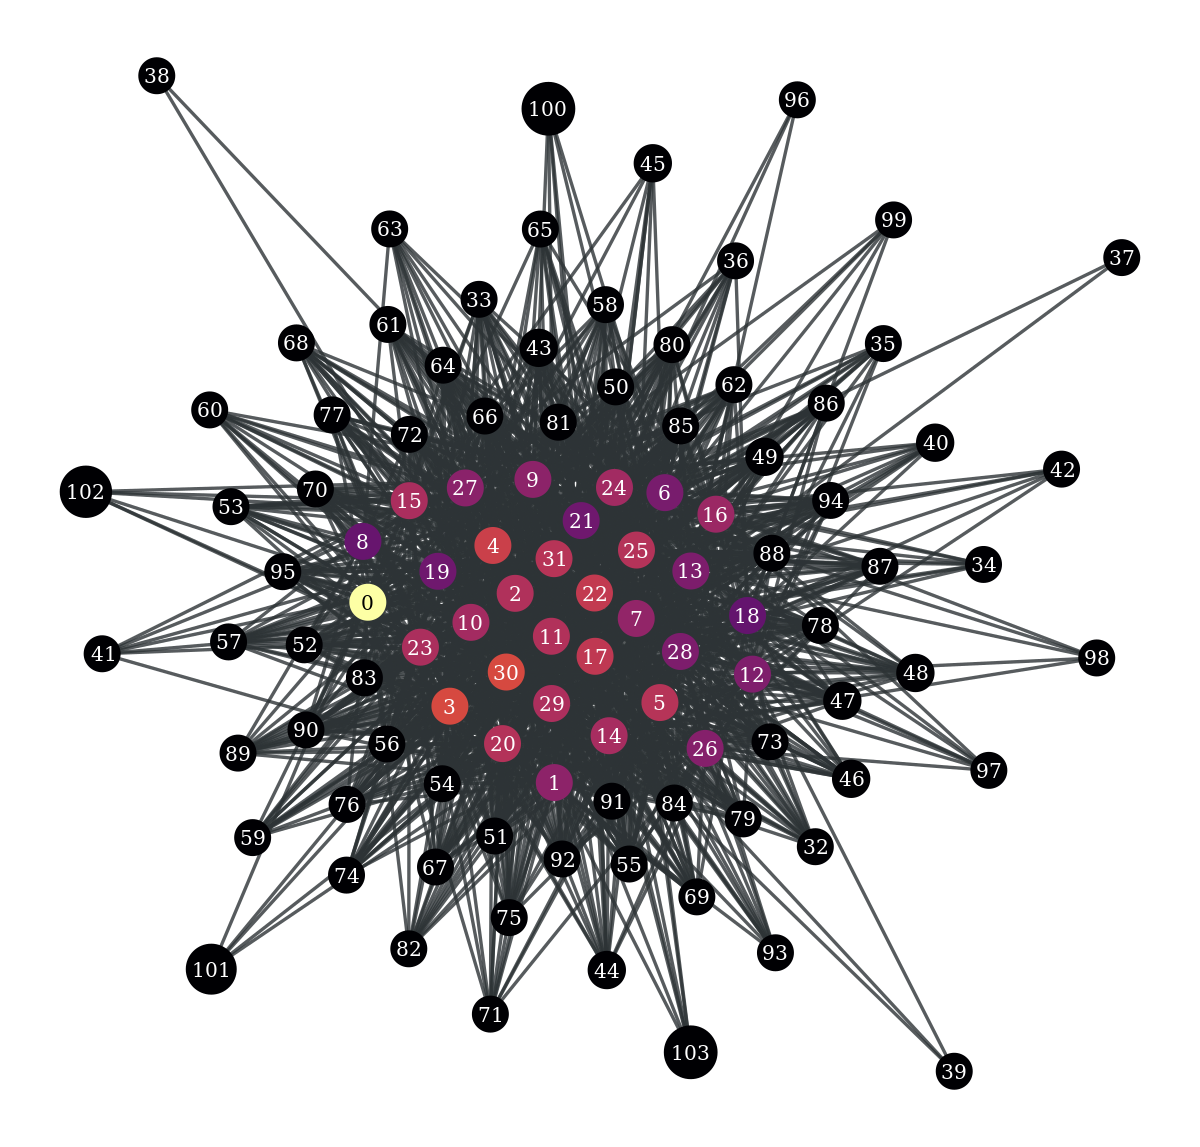

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2aa151e10, at 0x7fa2aa134f28>

In [27]:
s = topology.vertex_similarity(B_sub, "jaccard")
color = B_sub.new_vp("double")
color.a = s[0].a
draw.graph_draw(B_sub, pos=pos, vertex_text=B_sub.vertex_index,
              vertex_color=color, vertex_fill_color=color,
              vcmap=matplotlib.cm.inferno)

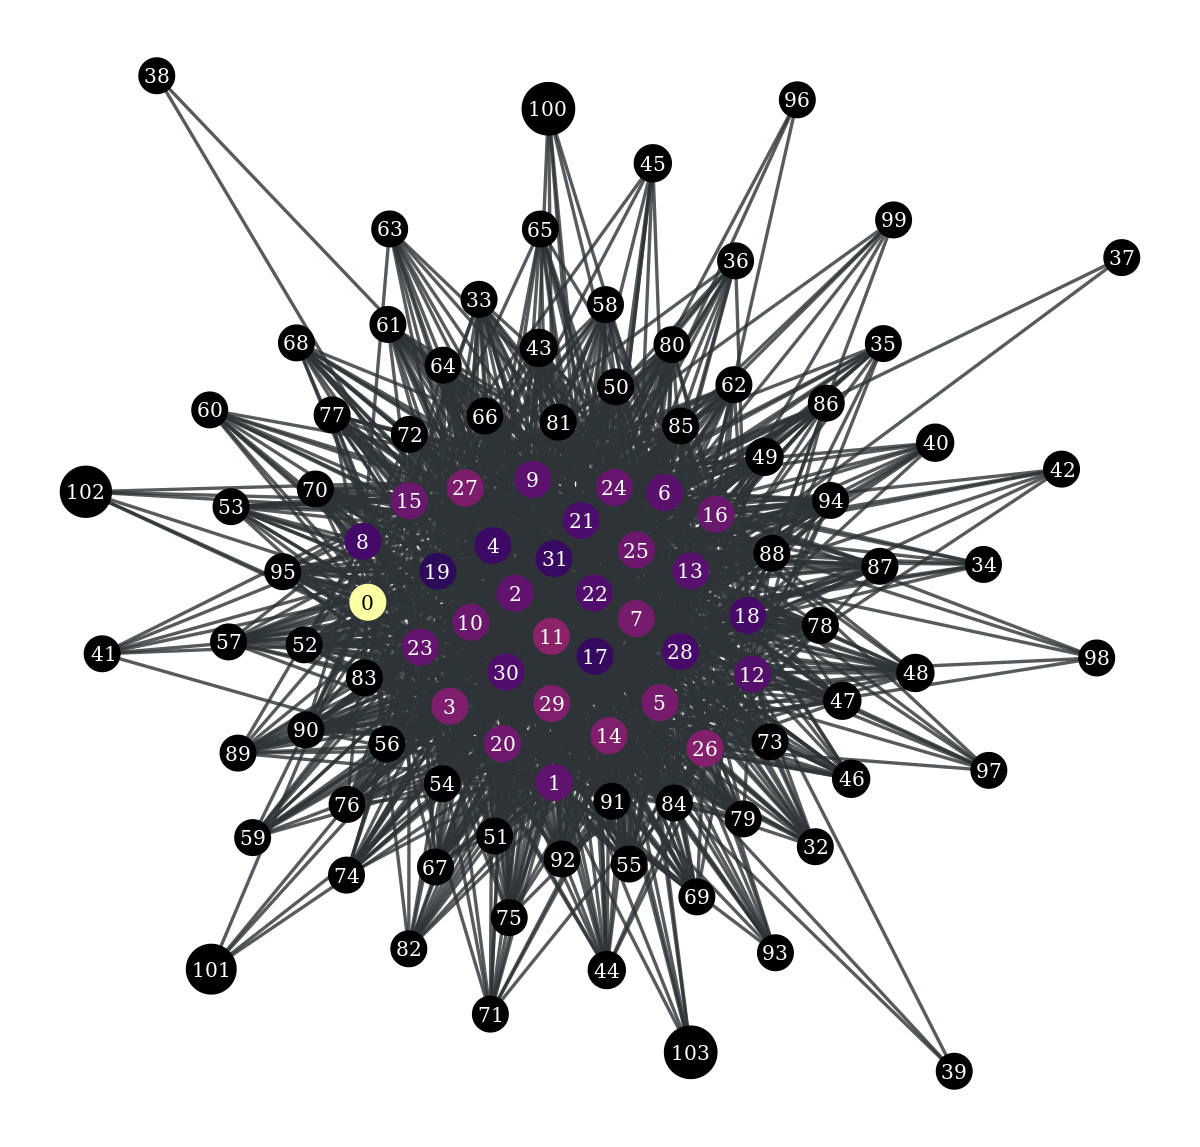

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2aa151e10, at 0x7fa2aa134f28>

In [28]:
s_w = topology.vertex_similarity(B_sub, "jaccard", eweight=B_sub.ep["eweight"])
color = B_sub.new_vp("double")
color.a = s_w[0].a
draw.graph_draw(B_sub, pos=pos, vertex_text=B_sub.vertex_index,
              vertex_color=color, vertex_fill_color=color,
              vcmap=matplotlib.cm.inferno)

In [39]:
import random
random.seed(27)

vertex_i = B_sub.vertex(random.randint(40, 100))
print("The most similar vertex to %s %s is:\n " % (B_sub.vp["vname"][vertex_i], B_sub.vp["cell_type"][vertex_i]))
print("From uni-weighted jaccard similarity")
for idx in np.flip(s[vertex_i].a.argsort())[1:5+1]:
    print(B_sub.vp["vname"][idx], B_sub.vp["cell_type"][idx])
    
print("\nFrom weighted jaccard similarity")
for idx in np.flip(s_w[vertex_i].a.argsort())[1:5+1]:
    print(B_sub.vp["vname"][idx], B_sub.vp["cell_type"][idx])

The most similar vertex to P60FCRep1P1_CTTCACATTGTC FC_6-4 is:
 
From uni-weighted jaccard similarity
P60FCRep1P1_GTCCAGTCAACC FC_6-1
P60FCRep3P4_AGACAAAGTGGG FC_6-4
P60FCRep4P2_CGTCGTAAAAAT FC_6-4
P60FCRep3P1_TTGCATGGAGAA FC_6-1
P60FCRep1P2_TTAACGCGGGCA FC_6-4

From weighted jaccard similarity
P60FCCx3cr1Rep1P3_GACTAGACCCAG FC_6-4
P60FCRep3P4_CTTCGGCAAGCT FC_6-3
P60FCRep2P2_AGTCTTAGCATN FC_6-4
P60FCRep2P1_TCTAGGGATCAG FC_6-1
P60FCRep2P1_AGCAACGTACCC FC_3-8


In [41]:
vertex_i = B_sub.vertex(random.randint(0, 30))
print("The most similar vertex to %s %s is:\n " % (B_sub.vp["vname"][vertex_i], B_sub.vp["cell_type"][vertex_i]))
print("From uni-weighted jaccard similarity")
for idx in np.flip(s[vertex_i].a.argsort())[1:5+1]:
    print(B_sub.vp["vname"][idx], B_sub.vp["cell_type"][idx])
    
print("\nFrom weighted jaccard similarity")
for idx in np.flip(s_w[vertex_i].a.argsort())[1:5+1]:
    print(B_sub.vp["vname"][idx], B_sub.vp["cell_type"][idx])

The most similar vertex to Map1lc3b  is:
 
From uni-weighted jaccard similarity
Ndrg4 
Uchl1 
Prdx2 
Purb 
Gcc2 

From weighted jaccard similarity
Prdx2 
1110008P14Rik 
Cit 
Smim13 
Eif1b 


The result seems make sense to me.    
First, from such easy graph similarity measurement, it finds out that genes are closer to genes not cells, and cells are closer to cells.  
Second, cells under similar cell types are more similar. For instance, the most similar cell types for a `FC_6-4` cell type are `FC_6-4`, `FC_6_1` which all belongs to `FC_6`.  
The finding supports that to construct RNA_seq data as a bipartite graph is benefitial.

## Community Detection

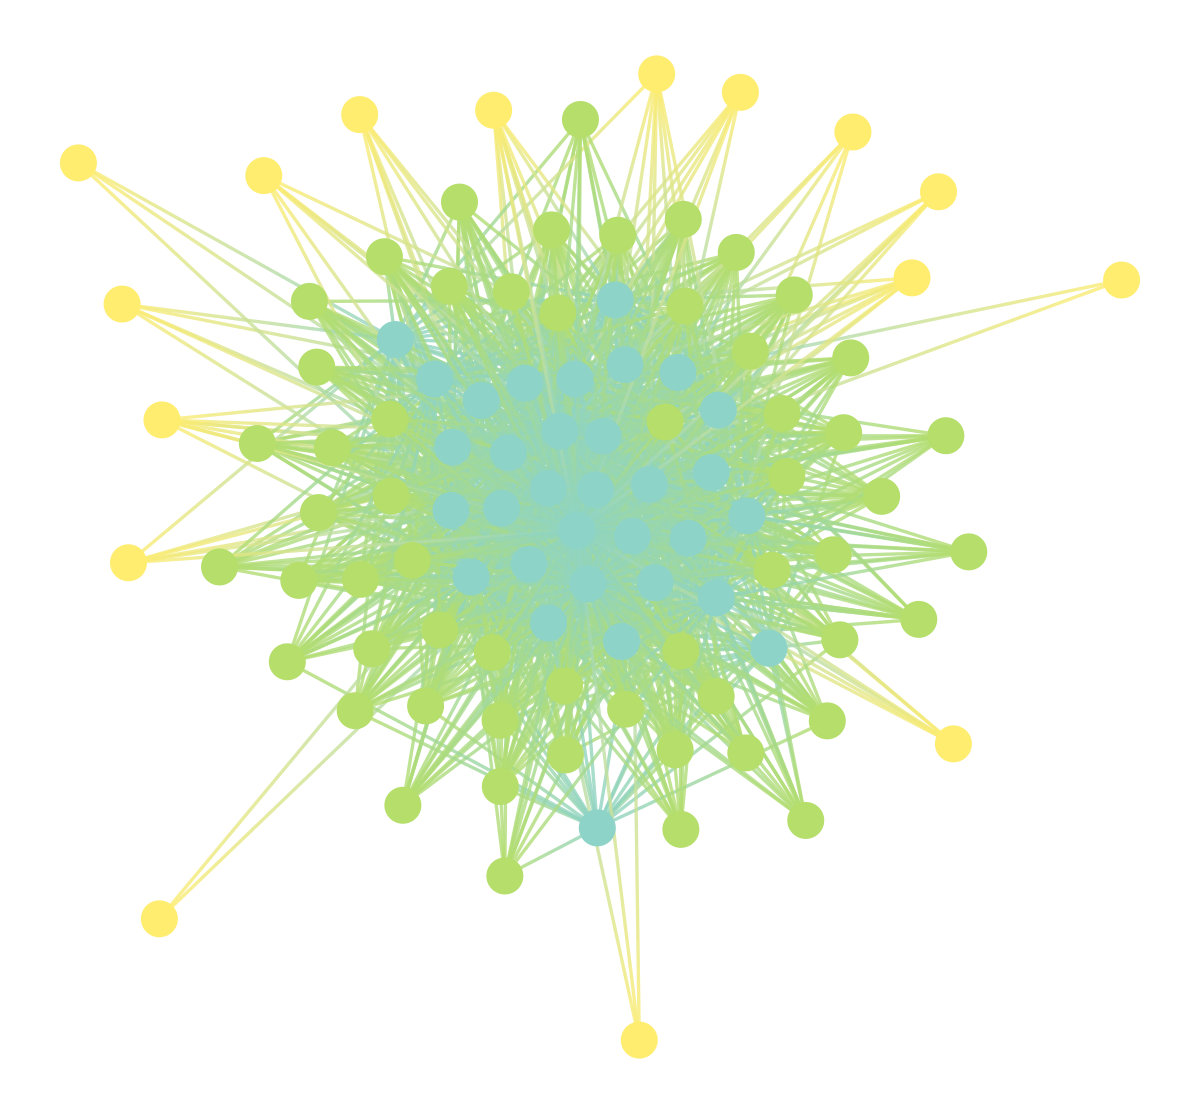

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2aa151e10, at 0x7fa45b190be0>

In [47]:
state = inference.minimize_blockmodel_dl(B_sub, deg_corr=False)
state.draw(pos=pos)

There are 3 potential communities in the constructed graph.   
It would be interesting to investigate how these communities inspire some biological findings.   
Since the data actually comes from my collaborator, I will leave this question open and investigate it in the future.

# Conclusion

To represent the RNA_seq data to graph structure provides a novel perspective for interpret this data.  
It is also possible to represent the data as other graph structures, e.g. multi-view graph.  
The network topology helps indentify similar gene pairs and cell pairs, which may provide some insights for biological findings. 


However, during this exploration, one major challenge is the scalability of graph analysis tools.  
The original data contains 15976 genes, and 71639 cells, which makes the computation efficiency a critical issue.  
I ends up using a subsampling to compute the graph propertites, and even further using a subgraph os the subsampling data for visulization.  
In this computational intensive senario, the C++ implemented graph-tool is preferable compared to networkx.  
A reliable sampling strategy or random graph generation method is needed for further studies.